In [1]:
import torch
from torch import nn
import lightning as L 
from dotenv import load_dotenv
import os
import numpy as np
import matplotlib.pyplot as plt
from typing import Literal

from transphorm.model_components.data_objects import SyntheticFPDataModule
from transphorm.model_components.model_modules import (
    AutoEncoder,
    BranchingCNNDecoder,
    BranchingCNNEncoder,
) 

In [2]:
data_path = os.getenv('DATA_PATH')
print(data_path)
model_path = '/Users/mds8301/Development/transphorm/models/autoencoders/37da8b1c4405475b8c4395fe394ab39d/checkpoints/branching_dilated_cnn_w_attention_v2.ckpt'
data_mod = SyntheticFPDataModule(data_path)
data_mod.prepare_data()
data_mod.setup('test')

model = AutoEncoder.load_from_checkpoint(model_path, encoder = BranchingCNNEncoder(), decoder = BranchingCNNDecoder())
model.to('cpu')

/Users/mds8301/Desktop/temp/synthetic_dataset.pt


AutoEncoder(
  (encoder): BranchingCNNEncoder(
    (local_branch): Sequential(
      (0): Conv1d(3, 16, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): ReLU()
      (2): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
      (3): ReLU()
    )
    (mid_branch): Sequential(
      (0): Conv1d(3, 16, kernel_size=(9,), stride=(1,), padding=(1,), dilation=(4,))
      (1): ReLU()
      (2): Conv1d(16, 32, kernel_size=(9,), stride=(1,), padding=(1,), dilation=(4,))
      (3): ReLU()
    )
    (long_brach): Sequential(
      (0): Conv1d(3, 16, kernel_size=(27,), stride=(1,), padding=(1,), dilation=(8,))
      (1): ReLU()
      (2): Conv1d(16, 32, kernel_size=(27,), stride=(1,), padding=(1,), dilation=(8,))
      (3): ReLU()
    )
    (fusion): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
    (self_attention): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
    )
  )
  (decoder): BranchingCNNDecoder(
    (self_

In [8]:
# model.encoder.to('cpu')
# model.encoder.eval()
x = data_mod.train[0][0].shape
x_hmodel(x)

AttributeError: 'torch.Size' object has no attribute 'grad'

In [4]:



class AutoEncoderAnalyzer:
    def __init__(self, model: L.LightningModule, data_module: L.LightningDataModule):
        self.model = model
        self.data_module = data_module

    def _detatch_tensor(self, tensor: torch.Tensor):
        tensor.to('cpu')
        return tensor.detach().numpy()
    
    def _get_random_instance(self, subset_category: Literal['test', 'val', 'train']):
        subset = {'test': self.data_module.test,
                  'val': self.data_module.val,
                  'train': self.data_module.train
                     }
        
        data = subset[subset_category]
        rand_idx = np.random.randint(0, len(data))

        return data[rand_idx][0].unsqueeze(0)
    
    def compute_random_inference(self, subset_category):
        x_test = self._get_random_instance(subset_category)
        with torch.no_grad():
            x_hat_test = self.model(x_test)
        x_test_samp = self._detatch_tensor(x_test.squeeze(0))
        x_hat_test_samp = self._detatch_tensor(x_hat_test.squeeze(0))
        return x_test_samp, x_hat_test_samp


        

    
    def plot_data(self, x, x_hat):
        fig, ax = plt.subplot_mosaic(mosaic='ABC', **{'figsize': (18,6)})
        ax['A'].plot(x[0], color = 'k')
        ax['A'].plot(x_hat[0], color = 'r')
        ax['B'].plot(x[1], color = 'k')
        ax['B'].plot(x_hat[1], color = 'r')
        ax['C'].plot(x[2], color = 'k')
        ax['C'].plot(x_hat[2], color = 'r')
        ax['A'].title.set_text('Signal')
        ax['B'].title.set_text('Timestamps vector 1')
        ax['C'].title.set_text('Timestamps vector 2')




In [5]:
analyzer = AutoEncoderAnalyzer(model, data_mod)

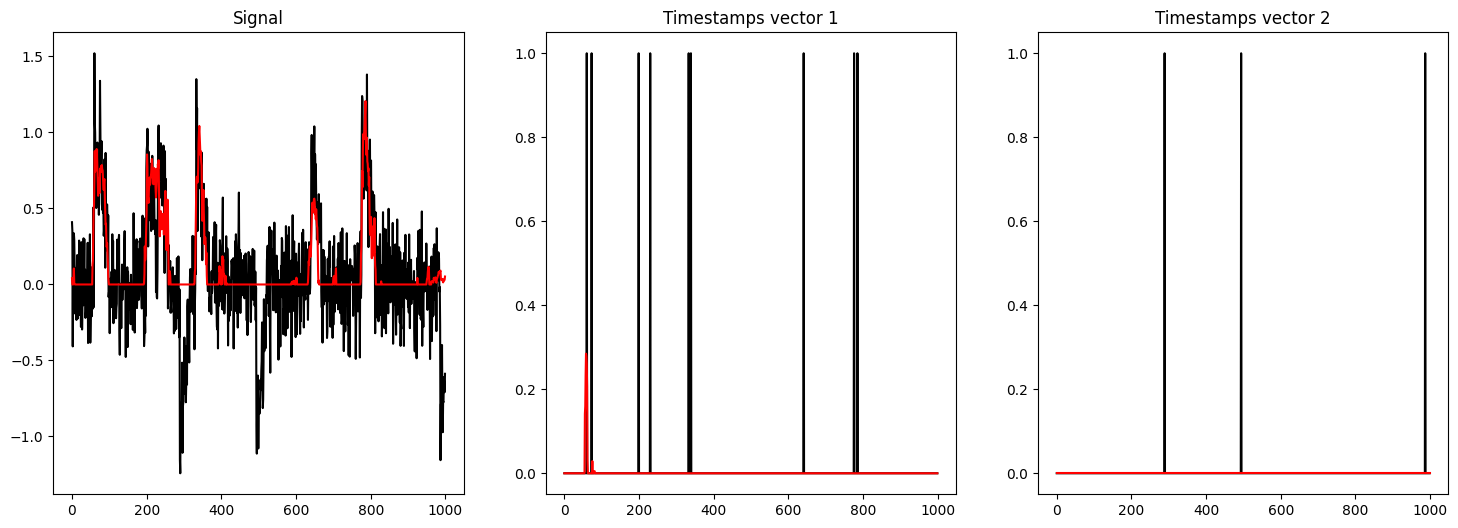

In [19]:
x, x_hat = analyzer.compute_random_inference(subset_category='train')
analyzer.plot_data(x, x_hat)

In [66]:
x_tens = torch.Tensor(x).unsqueeze(0)
enc = model.encoder(x_tens)
pool = nn.AdaptiveAvgPool1d(16)(enc).flatten()
pool.shape



torch.Size([1024])